# Teleporting Berlin Neighborhoods to Boston

In [1]:
# import libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from helpers import price_parse, percent_parse, valid_value_intbool, multicategorical_to_dummies, make_dummies
import locale; locale.setlocale(locale.LC_ALL, 'en_US.UTF-8');

## Reading and Joining Data

In [2]:
# read data and join
#Boston
bos_lis = pd.read_csv('data/boston/listings.csv', sep=',', header=0,
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated',
                                 'calendar_last_scraped', 'first_review', 'last_review'],
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse,
                                'monthly_price': price_parse, 'security_deposit': price_parse,
                                'cleaning_fee': price_parse, 'extra_people': price_parse,
                                'host_acceptance_rate': percent_parse, 'host_response_rate': percent_parse},
                    true_values=['t'], false_values=['f'],
                    index_col='id')
#Berlin
ber_lis = pd.read_csv('data/berlin/listings_summary.csv', sep=',', header=0,
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated',
                                 'calendar_last_scraped', 'first_review', 'last_review'],
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse,
                                'monthly_price': price_parse, 'security_deposit': price_parse,
                                'cleaning_fee': price_parse, 'extra_people': price_parse,
                                'host_acceptance_rate': percent_parse, 'host_response_rate': percent_parse},
                    true_values=['t'], false_values=['f'],
                    index_col='id')

C:\Users\ruindur\.conda\envs\airbnb_blog\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (28,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Pre-Processing and Cleanup

In [3]:
# Pre-Process
# join in here to avoid problems with dropped columns upon re-running
listings = pd.concat([bos_lis.assign(**{'source': lambda x: 'Boston'}),
                      ber_lis.assign(**{'source': lambda x: 'Berlin'})], axis=0,
                     ignore_index=True, sort=False).dropna(how='all', axis=1)
# column categories
listings_categorical = ['experiences_offered', 'host_location', 'host_response_time',
                        'host_neighbourhood',
                        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
                        'state', 'zipcode', 'market', 'source', 'smart_location',
                        'property_type', 'cancellation_policy',
                        'room_type', 'bed_type', 'calendar_updated']
listings_presence = [] # to be filled later
listings_text = ['name', 'summary', 'space', 'description', 'notes', 'neighborhood_overview',
                 'transit', 'host_about', 'host_name', 'street', 'neighborhood']
listings_multi_categories = ['amenities'] #,'host_verifications']
listings_numeric = listings.select_dtypes('number').columns

# actual URLs are not interesting, but presence could be of value
for col in listings.columns:
    if 'url' in col:
        pcol = 'has_' + col
        listings[pcol] = listings[col].apply(valid_value_intbool, convert_dtype=True)
        listings.drop(col, axis=1, inplace=True)
        listings_presence.append(pcol)

# expand the selected multi-catergorical columns to dummy variables
for col in listings_multi_categories:
    multicat = multicategorical_to_dummies(listings[col])
    listings = listings.join(multicat)
    listings.drop(col, axis=1)

# remove columns where all values are the same
listings_all_same = []
for col in listings_categorical:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_categorical.remove(col)

for col in listings_presence:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_presence.remove(col)

for col in listings_numeric:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_numeric.remove(col)

listings = listings.drop(listings_all_same, axis=1)
# display for visual check
listings.sample(10)

,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,...,amenities_Wide clearance to shower,amenities_Wide doorway,amenities_Wide entryway,amenities_Wide hallway clearance,amenities_Wifi,amenities_Window guards,amenities_Wireless Internet,amenities_toilet,amenities_translation missing: en.hosting_amenity_49,amenities_translation missing: en.hosting_amenity_50
13463,20181107122246,2018-11-07,Cozy Artistic Room in the historic Red Island.,Our place is close to Julius-Leber-Brücke S1 b...,NaN,Our place is close to Julius-Leber-Brücke S1 b...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,1,1
11943,20181107122246,2018-11-07,gemütliches Zimmer mit eigenem Bad,"großes Zimmer mit 1.80x 2m Doppelbett, großes ...",du wohnst in einem spannenden und interessante...,"großes Zimmer mit 1.80x 2m Doppelbett, großes ...",ganz in der Nähe und fußläufig erreichbar find...,Nichtraucher Haus,"gute Anbindung an öffentliche Verkehrsmittel, ...","Zimmer und Bad sind für dich/euch, Kühlschrank...",...,0,0,0,0,1,0,0,0,1,1
155,20160906204935,2016-09-07,"A quiet, green oasis in funky JP!","Enjoy hip JP! Tucked away in a verdant, calm o...","Welcome to a gardener's delight of a house, tu...","Enjoy hip JP! Tucked away in a verdant, calm o...",To gauge distances between my house and destin...,INSTRUCTIONS Please do take the time to read ...,To gauge distances between my house and destin...,"Full use of kitchen and cookware, college-size...",...,0,0,0,0,0,0,1,0,0,0
11592,20181107122246,2018-11-07,Medium-room Berlin!,Hello :) I have ONE private-room located 25min...,I have quite a simple and clean layout - my ro...,Hello :) I have ONE private-room located 25min...,"I live in quite a quiet neighbourhood, mostly ...",The flat is on the 6th floor which you can acc...,"The important part! From my door, it takes 2mi...",Your main living area would be my bedroom but ...,...,0,0,0,0,1,0,0,0,0,0
21012,20181107122246,2018-11-07,Cozy room in shared flat in Tempelhof,Light and cozy room is being rented out in Tem...,NaN,Light and cozy room is being rented out in Tem...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
3839,20181107122246,2018-11-07,*** modern-cozy-design apartment,NaN,The three-room-apartment is on the 4th floor i...,The three-room-apartment is on the 4th floor i...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
949,20160906204935,2016-09-07,"Modern 1BR in South End w/Gym, Pool",This brand new unit in one of Boston's most de...,Enjoy views of downtown Boston through the flo...,This brand new unit in one of Boston's most de...,"Walking distance to Boston Common, Chinatown, ...",NaN,"All of the South End, Chinatown, and the south...",There’s a gym on the 1st floor and a pool on t...,...,0,0,0,0,0,0,1,0,0,0
17485,20181107122246,2018-11-07,Big and sunny room in Neukölln,"The apartment is a large flat, with big window...",NaN,"The apartment is a large flat, with big window...",The flat is in the heart of the popular neighb...,NaN,- Easy and direct access from Schoenefeld airp...,"Private room, living room, kitchen and the bat...",...,0,0,0,0,1,0,0,0,0,0
3685,20181107122246,2018-11-07,Central Artist Appartement Prenzlauer Berg,Cozy room in two room Artist apt in the heart ...,Cozy and calm room in two room artist appartem...,Cozy room in two room Artist apt in the heart ...,"Lots of nice bars, restaurants and shops aroun...",You're welcome!,"M1, M12 Tram around the corner, U2 Subway & S-...",- Living Room - Bathroom - Kitchen,...,0,0,0,0,1,0,0,0,1,1
20074,20181107122246,2018-11-07,Cozy room 5 min walk from Checkpoint Charlie,The room is very light during the sunny weathe...,NaN,The room is very light during the sunny weathe...,The house is located in Berlin Mitte. To the ...,NaN,NaN,You have full access to 2 bathrooms (incl. was...,...,0,0,0,0,1,0,0,0,0,0


## Average Listing Properties by Neighbourhood
### Column Selection for Averaging

In [4]:
# no id columns here, no scrape metadata
aggregateable_cols = list(listings.columns)

# removing some columns that seem not useful
for col in listings.columns:
    if '_id' in col or 'scrape' in col:
        aggregateable_cols.remove(col)

# exclude columns that are uninterpretable or effectively random ids per listing, unsuitable for aggregation
exclude_columns = ['latitude', 'longitude', # purely geographic analysis
                   'amenities_', # artifact from multi-categorical expansion
                   'amenities_translation missing: en.hosting_amenity_49', # impossible to interpret
                   'amenities_translation missing: en.hosting_amenity_50', # impossible to interpret
                   'host_neighbourhood', # more interesting to check if host lives in same neighborhood as listing
                   'host_location', 'smart_location', # too spammy would map to large number of
                                                      # single true value indicator columns
                   'neighbourhood_cleansed', # too much correlation to neighborhood
                   'neighbourhood_group_cleansed', # same, maybe use as replacement for neighbourhood
                   'market', 'source', # will only create distance between Boston and Berlin neighbourhoods
                   'calendar_updated', # metadata, not descriptive of listing
                   'city', 'state', 'zipcode', 'country', 'country_code', 'street', # more geographic features and
                                                                                    # random labels
                   'host_acceptance_rate' # valid values only exist for Boston
                   ]

for col in exclude_columns:
    if col in aggregateable_cols:
        aggregateable_cols.remove(col)

dummy_cols = []
num_cols = []
for col in aggregateable_cols:
    if col in listings_categorical:
        dummy_cols.append(col)
    else:
        num_cols.append(col)
# output list of selected columns
print(*aggregateable_cols, sep=',\n')

name,
summary,
space,
description,
neighborhood_overview,
notes,
transit,
access,
interaction,
house_rules,
host_name,
host_since,
host_about,
host_response_time,
host_response_rate,
host_is_superhost,
host_listings_count,
host_total_listings_count,
host_verifications,
host_has_profile_pic,
neighbourhood,
is_location_exact,
property_type,
room_type,
accommodates,
bathrooms,
bedrooms,
beds,
bed_type,
amenities,
square_feet,
price,
weekly_price,
monthly_price,
security_deposit,
cleaning_fee,
guests_included,
extra_people,
minimum_nights,
maximum_nights,
has_availability,
availability_30,
availability_60,
availability_90,
availability_365,
number_of_reviews,
first_review,
last_review,
review_scores_rating,
review_scores_accuracy,
review_scores_cleanliness,
review_scores_checkin,
review_scores_communication,
review_scores_location,
review_scores_value,
requires_license,
license,
instant_bookable,
cancellation_policy,
require_guest_profile_picture,
require_guest_phone_verification,
calculat

## Average Listing Properties by Neighbourhood
### Normalize across whole data set

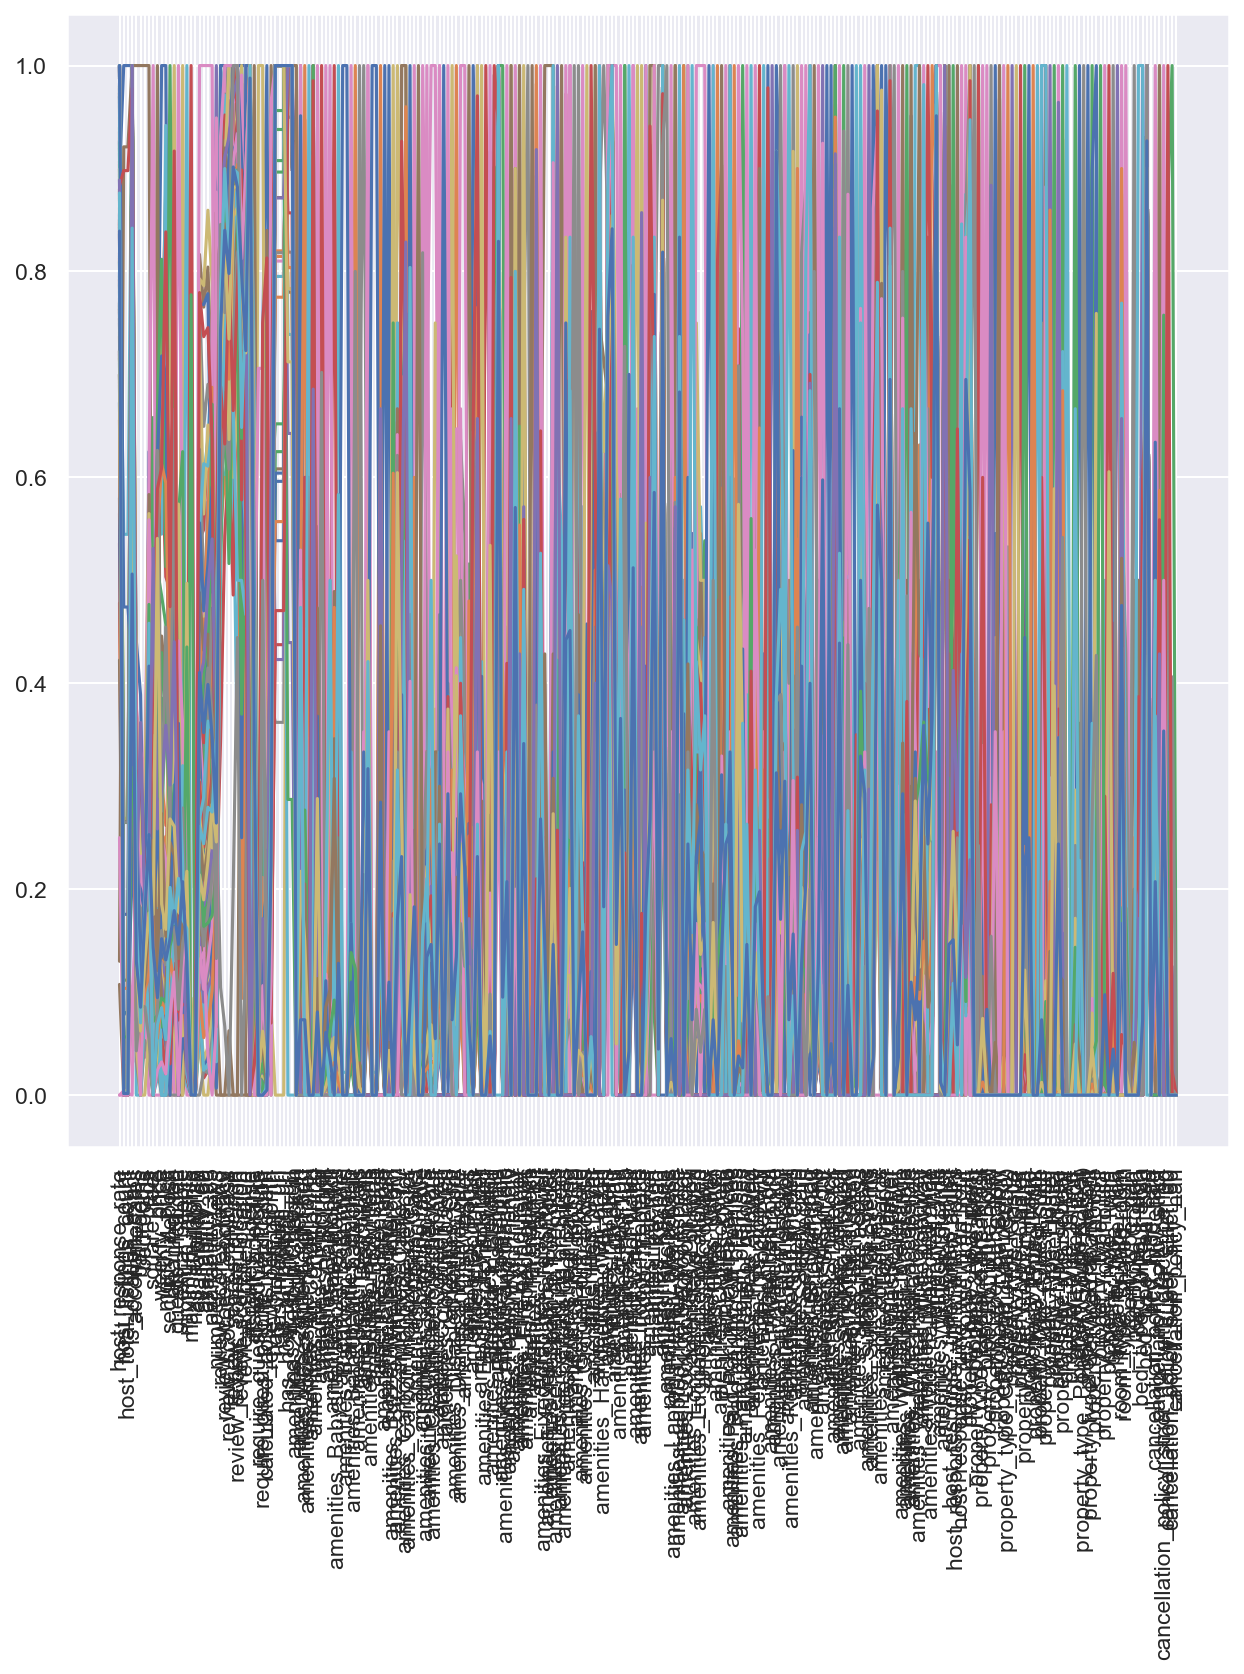

In [5]:
nbh_mean = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left') .groupby(['neighbourhood',]).mean()
# apply range normalization to avoid skewed factor weighting by scale without distorting distribution
nbh_mean_norm = nbh_mean.apply(lambda col: (col - col.min()) / (col.max() - col.min()))
plt.figure(figsize=(10,10), dpi=150)

# parallel coordinates plot to visually check if sufficient variability exists for meaningful grouping
for nbh in nbh_mean_norm.index:
    plt.plot(nbh_mean_norm.columns, nbh_mean_norm.fillna(0).loc[nbh], label=nbh)
plt.xticks(rotation=90);

In [6]:
print(nbh_mean.columns, sep=',\n')

Index(['host_response_rate', 'host_listings_count',
       'host_total_listings_count', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
       ...
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'bed_type_nan', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'cancellation_policy_nan'],
      dtype='object', length=252)


In [7]:
# get numbers of neighbourhoods per city
nbh_counts = listings.groupby('source')['neighbourhood'].value_counts()
ber_nbh_count = nbh_counts['Berlin'].index.shape[0]
ber_nbh_nam = list(nbh_counts['Berlin'].index)
bos_nbh_count = nbh_counts['Boston'].index.shape[0]
bos_nbh_nam = list(nbh_counts['Boston'].index)
print('Neighbourhoods in Boston: {}  | in Berlin {}'.format(bos_nbh_count, ber_nbh_count))

Neighbourhoods in Boston: 30  | in Berlin 91


### Normalize Grouped by City

In [8]:
nbh_mean_relative = nbh_mean.loc[ber_nbh_nam].apply(lambda col: (col - col.min()) / (col.max() - col.min()))
nbh_mean_relative = pd.concat((nbh_mean_relative,
                               nbh_mean.loc[bos_nbh_nam].apply(lambda col: (col - col.min()) / (col.max() - col.min()))))

nbh_mean_relative.sample(20)

,host_response_rate,host_listings_count,host_total_listings_count,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,cancellation_policy_nan
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Rahnsdorf,0.950000,0.003578,0.003578,0.944444,0.830409,0.603175,0.919192,0.903704,0.000000,0.350075,...,0.000000,0.000000,1.000000,NaN,0.259259,NaN,0.259259,0.000000,0.0,NaN
Kaulsdorf,0.835000,0.000947,0.000947,0.735294,0.650155,0.352941,1.000000,0.964706,1.000000,0.181099,...,0.000000,0.000000,1.000000,NaN,0.411765,NaN,0.352941,0.000000,0.0,NaN
Theater District,0.747586,0.263897,0.263897,1.000000,0.188661,0.181818,0.015152,0.131965,NaN,0.566874,...,0.000000,0.757576,0.696970,NaN,0.666667,0.333333,NaN,0.686869,NaN,NaN
Johannisthal,0.536000,0.002567,0.002567,0.478261,0.137300,0.149068,0.399209,0.330435,0.000000,0.121578,...,0.000000,0.521739,0.739130,NaN,0.478261,NaN,0.304348,0.000000,0.0,NaN
Roxbury,0.780416,0.034216,0.034216,1.000000,0.192436,0.160819,0.071121,0.176863,0.151261,0.266740,...,0.806897,0.646552,0.310345,NaN,0.500000,0.482759,NaN,0.000000,NaN,NaN
Reinickendorf,0.710909,0.008167,0.008167,0.687050,0.156759,0.055498,0.345978,0.210072,0.102434,0.074454,...,0.043165,0.302158,0.784173,NaN,0.287770,NaN,0.280576,0.000000,0.0,NaN
Rosenthal,0.580000,0.000000,0.000000,0.400000,0.442105,0.514286,0.563636,0.480000,0.333186,0.168331,...,0.000000,0.000000,1.000000,NaN,0.000000,NaN,0.200000,0.000000,0.0,NaN
East Boston,0.955008,0.008143,0.008143,1.000000,0.173422,0.119658,0.076923,0.148608,0.722689,0.184943,...,1.000000,0.000000,0.487179,NaN,0.632479,0.410256,NaN,0.048433,NaN,NaN
Französisch Buchholz,0.880000,0.002195,0.002195,0.863636,0.559809,0.389610,0.768595,0.581818,NaN,0.159824,...,0.000000,0.000000,1.000000,NaN,0.363636,NaN,0.136364,0.000000,0.0,NaN


## Comparing Neighourhoods by Properties
### Normalized Globally

In [9]:
print(*list(nbh_mean.columns), sep='\n')


host_response_rate
host_listings_count
host_total_listings_count
is_location_exact
accommodates
bathrooms
bedrooms
beds
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
requires_license
instant_bookable
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
reviews_per_month
has_thumbnail_url
has_medium_url
has_xl_picture_url
has_host_thumbnail_url
has_host_picture_url
amenities_24-Hour Check-in
amenities_24-hour check-in
amenities_Accessible-height bed
amenities_Accessible-height toilet
amenities_Air Conditioning
amenities_Air conditioning
amenities_Air purifier
amenities_BBQ grill
amenities_Baby bath
ame

In [10]:
# distance matrix for comparison
disfr = pd.DataFrame(index=nbh_mean_norm.loc[ber_nbh_nam].index)
for cindex, cvals in nbh_mean_norm.loc[bos_nbh_nam].iterrows():
    disfr[cindex] = nbh_mean_norm.loc[ber_nbh_nam].apply(lambda x: np.sqrt(np.sum(np.power(x - cvals.values, 2))),
                                                         axis='columns')
# for heatmap, order rows and columns to have smallest distances top and left
disfr['rowmin'] = disfr.min(axis=1)
disfr.loc['colmin'] = disfr.min(axis=0)
disfr.sort_values(by='rowmin', axis=0, inplace=True)
disfr.sort_values(by='colmin', axis=1, inplace=True)
disfr.drop('rowmin', axis=1, inplace=True)
disfr.drop('colmin', axis=0, inplace=True)

In [11]:
disfr.head(125)


,Roxbury,Allston-Brighton,Dorchester,Somerville,Mission Hill,Hyde Park,Beacon Hill,Charlestown,East Boston,Jamaica Plain,...,Theater District,Financial District,Downtown,Cambridge,Leather District,Downtown Crossing,Chinatown,West End,Harvard Square,Government Center
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Grünau,3.503528,3.573873,3.568362,3.641926,3.628439,3.710053,3.739248,3.760516,3.804246,3.780230,...,4.163240,4.270922,4.310174,4.535508,4.622122,4.681304,4.909323,5.023425,5.260916,6.021689
Tempelhof,3.538293,3.539580,3.602395,3.645163,3.625354,3.772592,3.720945,3.775894,3.784485,3.805250,...,4.050689,4.212982,4.293605,4.584638,4.596371,4.589729,4.860989,4.978911,5.187930,5.940289
Baumschulenweg,3.591548,3.587085,3.595715,3.612493,3.655294,3.770981,3.767750,3.809480,3.765719,3.790678,...,4.131937,4.259126,4.348819,4.629273,4.615069,4.629824,4.939034,5.063731,5.282368,6.001504
Neukölln,3.647823,3.609287,3.689358,3.697255,3.700298,3.871232,3.786804,3.873752,3.883917,3.896785,...,4.164898,4.306484,4.388249,4.705156,4.663942,4.695962,4.990484,5.102995,5.306491,6.052510
Alt-Treptow,3.702529,3.649894,3.729743,3.780778,3.732917,3.918985,3.810103,3.871600,3.894885,3.899858,...,4.176430,4.310852,4.421586,4.745567,4.646136,4.658114,4.977387,5.083004,5.264586,6.016731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Karow,5.517109,5.638976,5.560572,5.696316,5.766609,5.595618,5.819869,5.669938,5.655999,5.652556,...,6.034389,6.087412,6.165012,6.310460,6.239479,6.385981,6.431107,6.517708,6.826700,7.206818
Haselhorst,5.690229,5.846997,5.770756,5.790868,6.007663,5.862447,5.907356,5.854687,5.694139,5.872448,...,6.196741,6.278523,6.281421,6.427871,6.314767,6.359241,6.597572,6.787731,6.994807,7.388941
Falkenberg,5.799958,5.817294,5.843918,5.871160,5.862820,5.924955,5.952150,5.893046,5.863614,5.960798,...,6.095540,6.261925,6.290996,6.259732,6.395110,6.367136,6.336805,6.483164,6.780233,7.178764


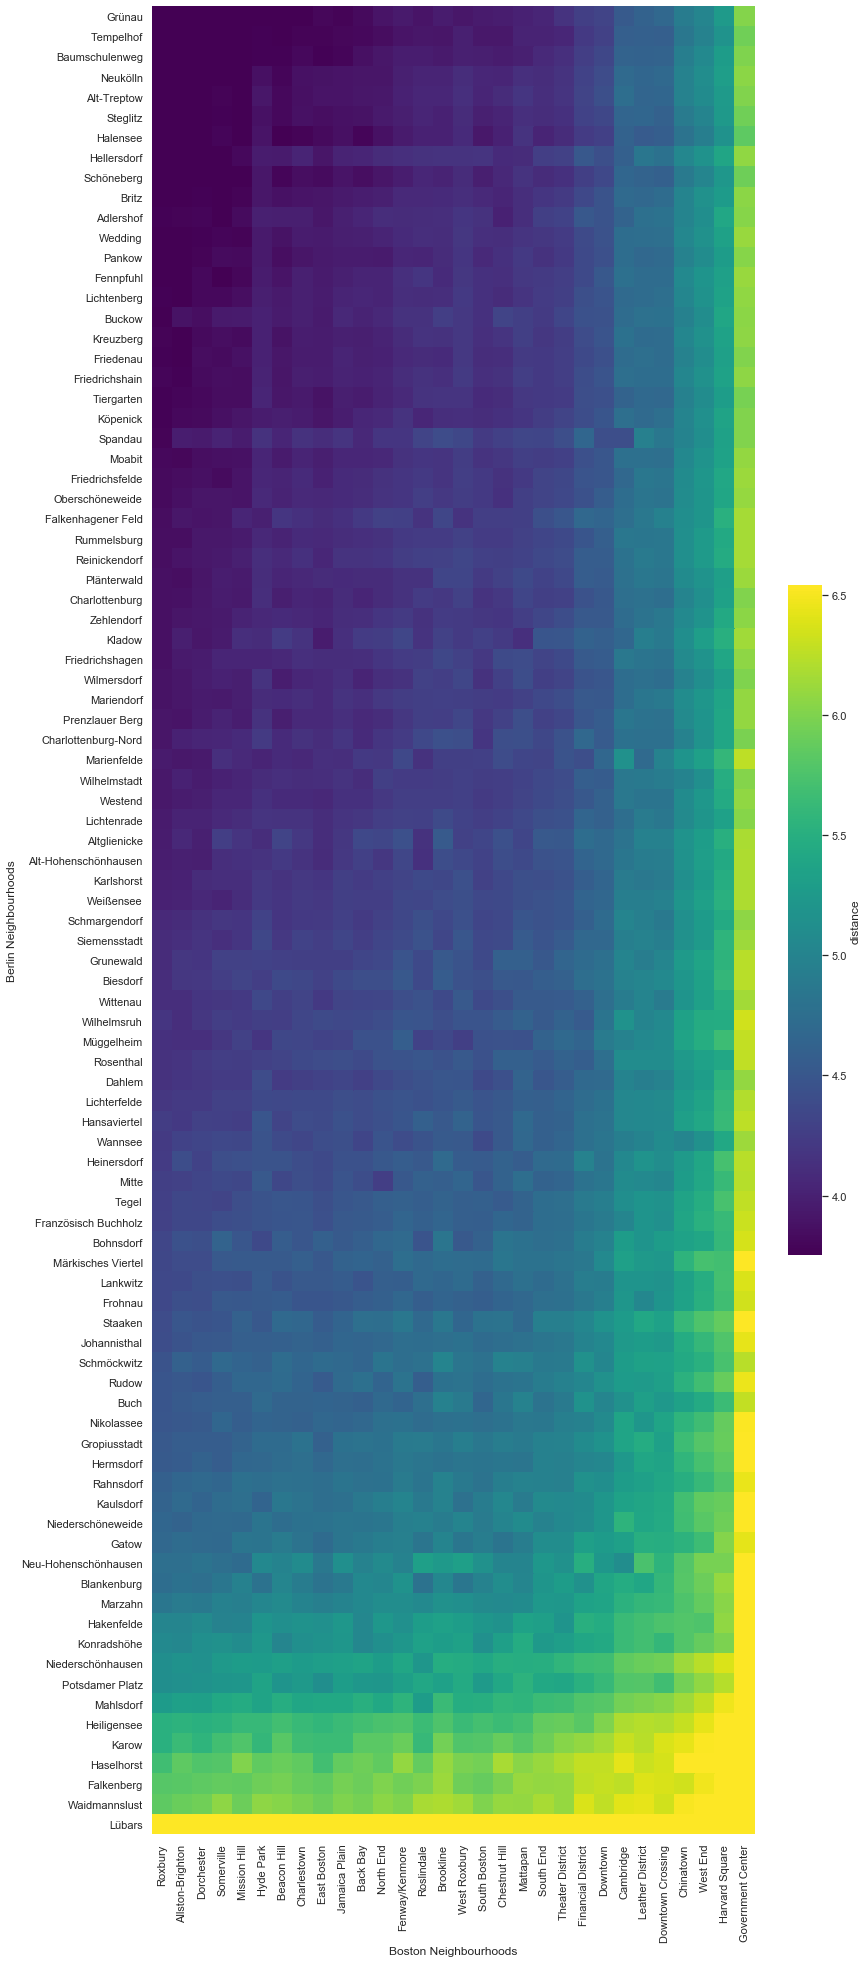

In [12]:
fix, ax = plt.subplots(figsize=(12,36))
sns.heatmap(disfr, annot=False, ax=ax, cmap='viridis', square=True, robust=True, cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
ax.set_xlabel('Boston Neighbourhoods')
ax.set_ylabel('Berlin Neighbourhoods')
plt.savefig('output/similarity_heatmap.png', bbox_inches='tight')

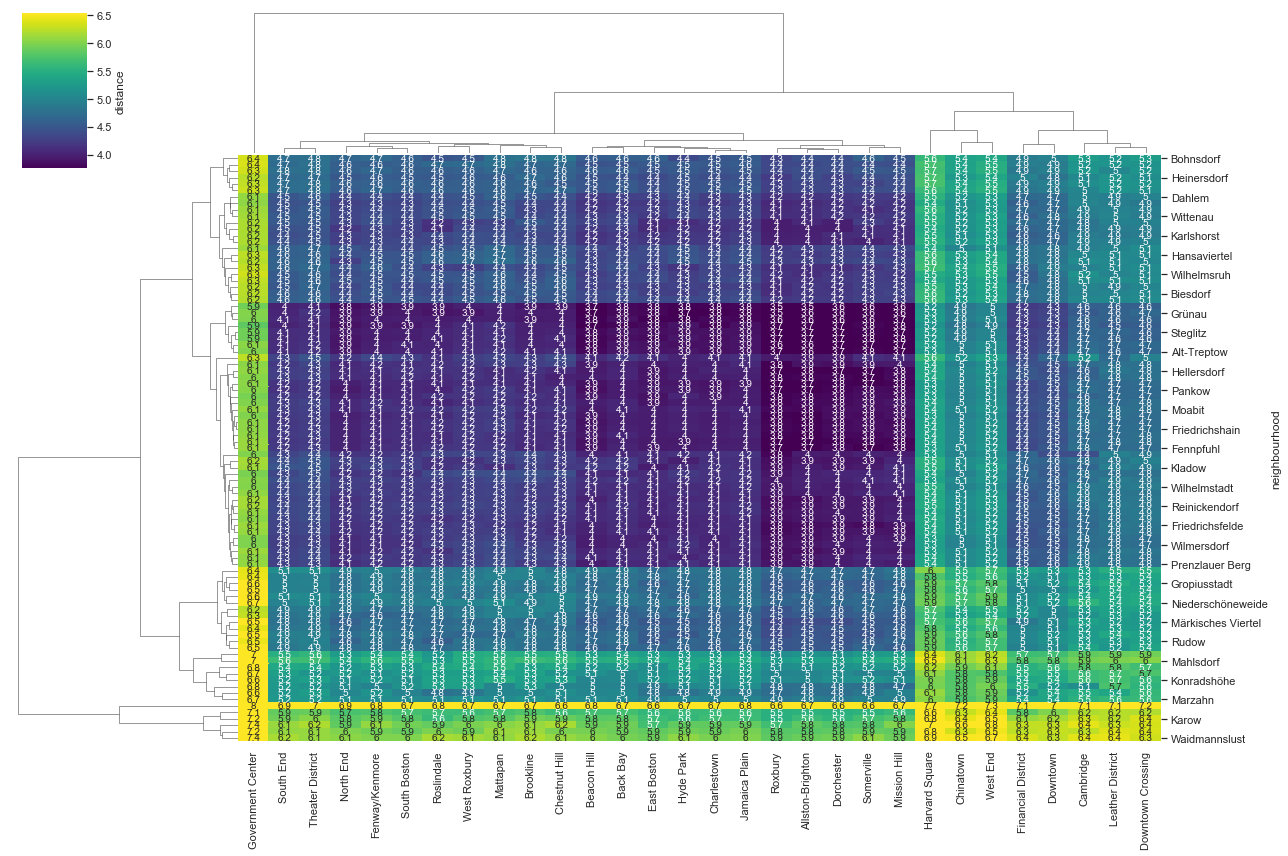

In [13]:
cgrid = sns.clustermap(disfr, annot=False, cmap='viridis', robust=True, figsize=(18,12), cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
plt.savefig('output/similarity_clustermap.png', bbox_inches='tight')

In [14]:
closest = pd.DataFrame(disfr.min(axis=0), columns=['distance'])
closest['neighbourhood'] = disfr.idxmin(axis=0)
closest['sigma'] = disfr.std(axis=0)
closest.sort_values(by='neighbourhood', ascending=True, inplace=True)
closest.head(30)

,distance,neighbourhood,sigma
Somerville,3.612493,Baumschulenweg,0.590799
East Boston,3.765719,Baumschulenweg,0.549517
Mattapan,3.997293,Baumschulenweg,0.534375
Roxbury,3.503528,Grünau,0.588984
Dorchester,3.568362,Grünau,0.584180
Hyde Park,3.710053,Grünau,0.564341
Charlestown,3.760516,Grünau,0.563414
Jamaica Plain,3.780230,Grünau,0.562998
Roslindale,3.902181,Grünau,0.536147
West Roxbury,3.925591,Grünau,0.528299


In [15]:
# count occurrences of Berlin neighbourhoods to assess similarity
closest['neighbourhood'].value_counts()

Tempelhof         10
Halensee           9
Grünau             7
Baumschulenweg     3
Spandau            1
Name: neighbourhood, dtype: int64

In [16]:
# average similarity per Berlin Neighborhood to assess "Bostonness"
print(disfr.mean(axis=1).sort_values().to_string(max_rows=None))
print(disfr.min(axis=1).sort_values().to_string(max_rows=None))


neighbourhood
Tempelhof               4.113126
Grünau                  4.131900
Baumschulenweg          4.151153
Halensee                4.156980
Schöneberg              4.194164
Steglitz                4.196302
Neukölln                4.212394
Alt-Treptow             4.227611
Britz                   4.254718
Pankow                  4.262643
Tiergarten              4.281552
Wedding                 4.288092
Friedenau               4.293821
Adlershof               4.300794
Hellersdorf             4.300922
Fennpfuhl               4.301324
Köpenick                4.306733
Kreuzberg               4.307247
Lichtenberg             4.307447
Friedrichshain          4.311725
Moabit                  4.340499
Buckow                  4.340554
Charlottenburg          4.361645
Friedrichsfelde         4.366671
Wilmersdorf             4.379357
Oberschöneweide         4.380443
Zehlendorf              4.389822
Plänterwald             4.398415
Spandau                 4.405107
Prenzlauer Berg         4.405

### Normalized by City

In [17]:
# distance matrix for comparison
dis_rel = pd.DataFrame(index=nbh_mean_relative.loc[ber_nbh_nam].index)
for cindex, cvals in nbh_mean_relative.loc[bos_nbh_nam].iterrows():
    dis_rel[cindex] = nbh_mean_relative.loc[ber_nbh_nam].apply(
        lambda x: np.sqrt(np.sum(np.power(x - cvals.values, 2))), axis='columns')
# for heatmap, order rows and columns to have smallest distances top and left
dis_rel['rowmin'] = dis_rel.min(axis=1)
dis_rel.loc['colmin'] = dis_rel.min(axis=0)
dis_rel.sort_values(by='rowmin', axis=0, inplace=True)
dis_rel.sort_values(by='colmin', axis=1, inplace=True)
dis_rel.drop('rowmin', axis=1, inplace=True)
dis_rel.drop('colmin', axis=0, inplace=True)
dis_rel.head(125)

,Beacon Hill,South Boston,South End,Allston-Brighton,Brookline,Mission Hill,Back Bay,Fenway/Kenmore,Charlestown,Theater District,...,Jamaica Plain,Financial District,Chestnut Hill,Mattapan,Leather District,Harvard Square,Cambridge,Chinatown,Government Center,West End
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Prenzlauer Berg,1.519248,1.696463,1.715627,1.936558,2.156936,2.061146,2.052931,2.083936,2.074734,2.137515,...,2.604250,2.533446,2.754254,3.069021,2.783240,3.192239,3.222668,3.386090,3.526628,3.524449
Schöneberg,1.561198,1.664407,1.730717,1.907310,2.051267,2.015680,2.042184,2.038845,2.061124,2.115861,...,2.548263,2.438584,2.710832,2.957900,2.801450,3.159858,3.199498,3.368760,3.463271,3.499400
Charlottenburg,1.582531,1.616284,1.697665,1.862412,1.983912,1.987866,2.037957,2.000705,2.056089,2.026203,...,2.582339,2.448275,2.626003,2.918729,2.783022,3.109598,3.079362,3.278642,3.345849,3.401587
Buckow,1.597956,1.765892,1.718200,2.097686,2.258656,2.199702,2.113103,2.251144,2.059814,2.323102,...,2.639342,2.576851,3.036458,2.943685,2.899913,3.403137,3.123410,3.375993,3.621186,3.493641
Kreuzberg,1.610851,1.855493,1.819376,1.875406,2.167253,1.995817,2.179915,2.175405,2.137343,2.232522,...,2.592263,2.571655,2.757206,3.000194,2.860775,3.373937,3.338268,3.538338,3.681148,3.650572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Waidmannslust,3.412655,2.923299,3.276379,3.032544,3.515011,3.149595,3.114701,3.262100,3.424170,3.003355,...,3.361574,3.868240,3.760855,3.579278,3.755622,3.900060,3.899046,4.096958,4.117776,4.318242
Lübars,3.576089,3.127625,3.511895,3.326907,2.871336,3.423734,3.612561,3.418112,3.553641,3.642406,...,3.669279,3.907556,2.906013,3.291178,3.653648,4.541258,3.865391,4.136187,4.335083,4.335610
Neu-Hohenschönhausen,3.449530,3.502694,3.447335,2.960963,3.530842,2.943341,3.670813,3.338066,3.809338,3.403772,...,3.927238,3.991285,3.491922,3.462166,4.299539,4.033327,3.349696,4.568244,4.710408,4.736495


In [18]:
closest_rel = pd.DataFrame(dis_rel.min(axis=0), columns=['distance'])
closest_rel['neighbourhood'] = dis_rel.idxmin(axis=0)
closest_rel['sigma'] = dis_rel.std(axis=0)
closest_rel.sort_values(by='neighbourhood', ascending=True, inplace=True)
closest_rel.head(30)

,distance,neighbourhood,sigma
Somerville,2.117025,Adlershof,0.361708
Dorchester,2.085518,Baumschulenweg,0.338584
Downtown,2.186124,Buckow,0.341984
South Boston,1.616284,Charlottenburg,0.372860
South End,1.697665,Charlottenburg,0.421029
Fenway/Kenmore,2.000705,Charlottenburg,0.363437
Theater District,2.026203,Charlottenburg,0.356715
Government Center,3.189427,Dahlem,0.271961
Mission Hill,1.866061,Hellersdorf,0.400314
Mattapan,2.553599,Kladow,0.301913


In [19]:
closest_rel['neighbourhood'].value_counts()


Charlottenburg       4
Wannsee              2
Kladow               2
Tegel                2
Westend              2
Mitte                1
Adlershof            1
Buckow               1
Siemensstadt         1
Dahlem               1
Niederschönhausen    1
Prenzlauer Berg      1
Lichtenrade          1
Staaken              1
Rummelsburg          1
Wilmersdorf          1
Baumschulenweg       1
Marienfelde          1
Reinickendorf        1
Steglitz             1
Potsdamer Platz      1
Hellersdorf          1
Spandau              1
Name: neighbourhood, dtype: int64

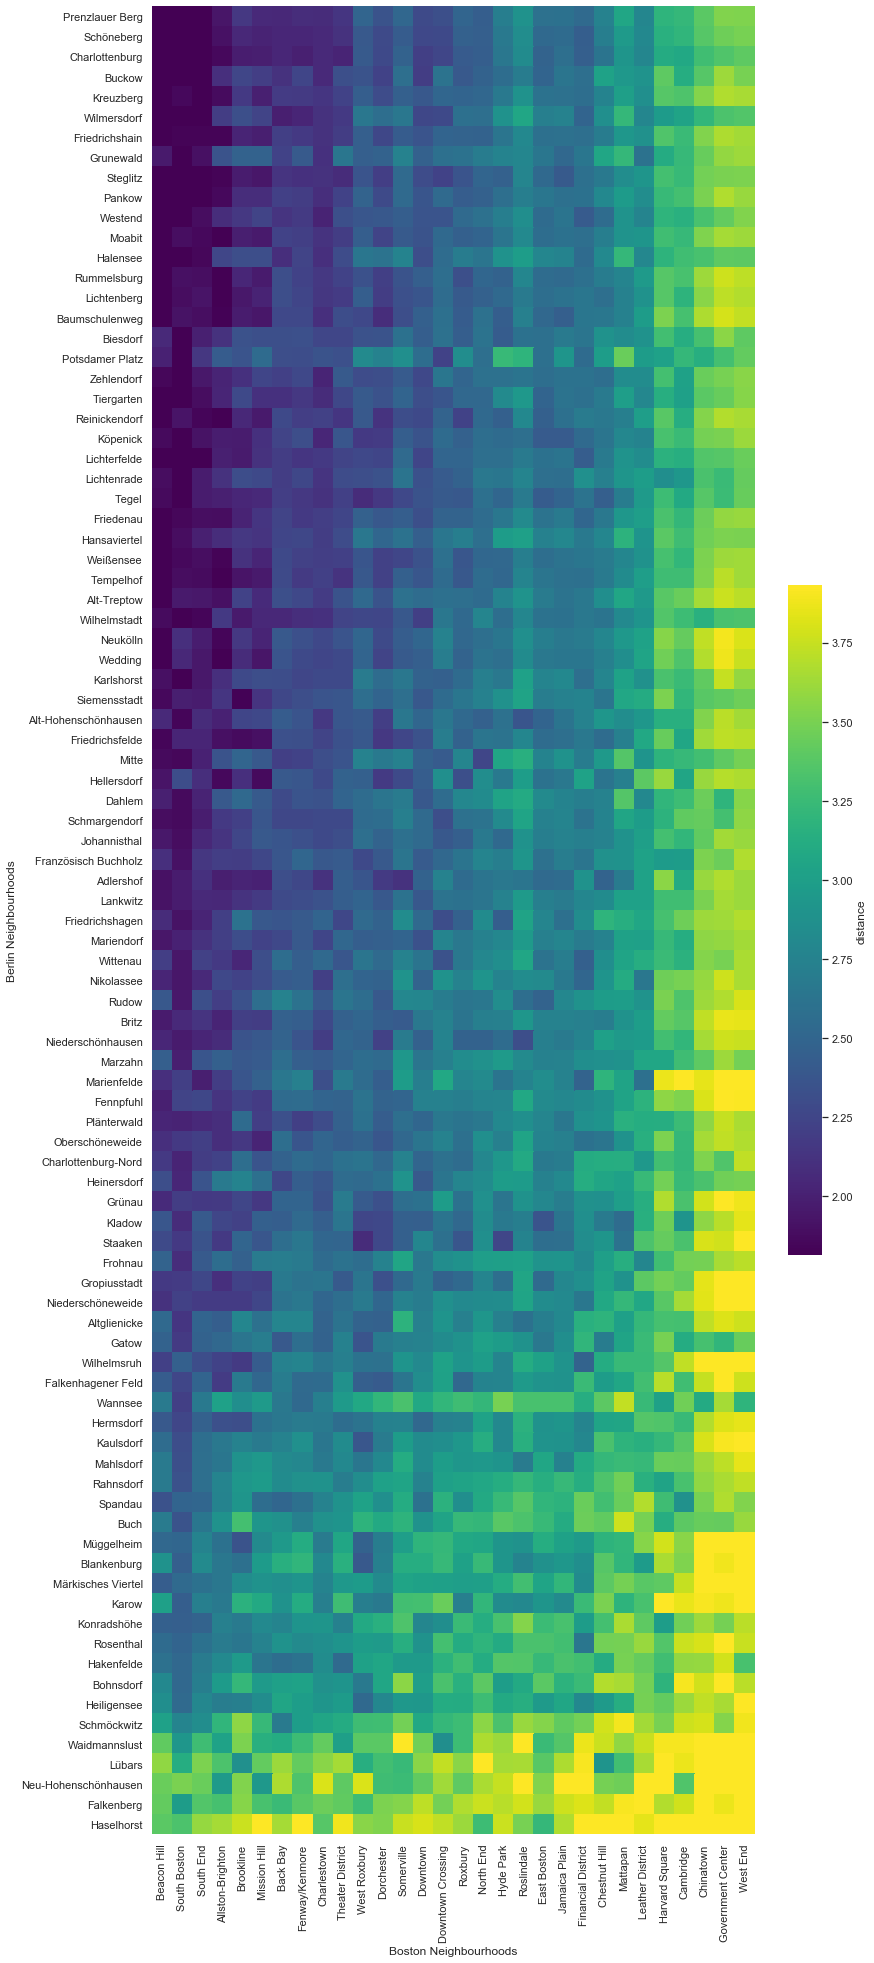

In [20]:
# distance heatmap
fix, ax = plt.subplots(figsize=(12,36))
sns.heatmap(dis_rel, annot=False, ax=ax, cmap='viridis', square=True, robust=True, cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
ax.set_xlabel('Boston Neighbourhoods')
ax.set_ylabel('Berlin Neighbourhoods')
plt.savefig('output/relative_heatmap.png', bbox_inches='tight')


### Reverse relative comparison out of curiosity

In [21]:
ber_closest_rel = pd.DataFrame(dis_rel.min(axis=1), columns=['distance'])
ber_closest_rel['neighbourhood'] = dis_rel.idxmin(axis=1)
ber_closest_rel['sigma'] = dis_rel.std(axis=1)

In [22]:
ber_closest_rel.loc[closest_rel['neighbourhood'].value_counts().index].head(35)

,distance,neighbourhood,sigma
Charlottenburg,1.582531,Beacon Hill,0.505302
Wannsee,2.203323,South Boston,0.337387
Kladow,2.074906,South Boston,0.448899
Tegel,1.754543,South Boston,0.460358
Westend,1.661101,South Boston,0.474432
Mitte,1.850666,South Boston,0.459484
Adlershof,1.908770,Beacon Hill,0.518222
Buckow,1.597956,Beacon Hill,0.519542
Siemensstadt,1.826311,Brookline,0.481083
Dahlem,1.863506,South Boston,0.428410


In [23]:
closest_rel.sort_values(by=['neighbourhood']).head(35)

,distance,neighbourhood,sigma
Somerville,2.117025,Adlershof,0.361708
Dorchester,2.085518,Baumschulenweg,0.338584
Downtown,2.186124,Buckow,0.341984
South Boston,1.616284,Charlottenburg,0.372860
South End,1.697665,Charlottenburg,0.421029
Fenway/Kenmore,2.000705,Charlottenburg,0.363437
Theater District,2.026203,Charlottenburg,0.356715
Government Center,3.189427,Dahlem,0.271961
Mission Hill,1.866061,Hellersdorf,0.400314
Mattapan,2.553599,Kladow,0.301913


## Analysis of the Influence of Listing Properties
### Boston vs Berlin

In [24]:
# get total variances and means, and neighborhood variances of properties to see which differences are
# statistically relevant
glob_mean = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left').mean()
nbh_std = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left')\
    .groupby(['neighbourhood',]).std()
glob_std = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left').std()

### Relevance for Distinguishing between Cities

In [25]:
city_mean = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left')\
    .join(listings['source'], how='left').groupby(['source']).mean()
city_std = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left')\
    .join(listings['source'], how='left').groupby(['source']).std()

In [26]:
city_counts = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left')\
    .join(listings['source'], how='left').groupby(['source'])[city_std.columns].count()

#### city means

In [27]:
city_mean.head(10)


,host_response_rate,host_listings_count,host_total_listings_count,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,cancellation_policy_nan
source,,,,,,,,,,,,,,,,,,,,,
Berlin,0.918985,2.330685,2.330685,0.743881,2.637460,1.092695,1.161134,1.620558,465.401345,67.143668,...,0.010642,0.019998,0.965147,0.0,0.314651,0.000000,0.278778,0.00235,0.000621,0.0
Boston,0.949891,58.902371,58.902371,0.859135,3.041283,1.221647,1.255944,1.609060,858.464286,173.925802,...,0.014226,0.008647,0.963180,0.0,0.256346,0.441283,0.000000,0.02371,0.000000,0.0


#### city standard deviations

In [28]:
city_std.head(10)

,host_response_rate,host_listings_count,host_total_listings_count,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,cancellation_policy_nan
source,,,,,,,,,,,,,,,,,,,,,
Berlin,0.193761,19.947823,19.947823,0.436498,1.510548,0.329894,0.646156,1.174840,503.491935,220.266210,...,0.102612,0.139997,0.183411,0.0,0.464387,0.00000,0.448408,0.048422,0.024908,0.0
Boston,0.125177,171.119663,171.119663,0.347930,1.778929,0.501487,0.753060,1.011745,608.874310,148.331321,...,0.118438,0.092600,0.188346,0.0,0.436676,0.49661,0.000000,0.152165,0.000000,0.0


#### valid value counts per city

In [29]:
city_counts.head(10)

,host_response_rate,host_listings_count,host_total_listings_count,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,cancellation_policy_nan
source,,,,,,,,,,,,,,,,,,,,,
Berlin,9657,22526,22526,22552,22552,22520,22534,22512,446,22552,...,22552,22552,22552,22552,22552,22552,22552,22552,22552,22552
Boston,3114,3585,3585,3585,3585,3571,3575,3576,56,3585,...,3585,3585,3585,3585,3585,3585,3585,3585,3585,3585


In [30]:
city_t = ((city_mean - glob_mean) / (glob_std / np.sqrt(city_counts))).abs()

#### city t-values

In [31]:
city_t.head(10)

,host_response_rate,host_listings_count,host_total_listings_count,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,cancellation_policy_nan
source,,,,,,,,,,,,,,,,,,,,,
Berlin,4.115151,16.929211,16.929211,5.556111,5.344748,7.336991,2.941073,0.204938,1.746218,10.229817,...,0.703530,1.737806,0.220119,NaN,2.604487,38.116893,13.434756,6.070889,0.552638,NaN
Boston,7.246822,42.435975,42.435975,13.935381,13.405258,18.424989,7.383919,0.514200,4.928015,25.657586,...,1.764535,4.358622,0.552086,NaN,6.532359,95.601663,33.695953,15.226504,1.386081,NaN


#### comparing t to the 95% 100-sample threshold value

In [32]:
# since only 2 samples exist, examining one is enough, we choose Boston
bos_t = city_t.loc['Boston'].gt(2.364)
print(bos_t.to_string(max_rows=None))

host_response_rate                                  True
host_listings_count                                 True
host_total_listings_count                           True
is_location_exact                                   True
accommodates                                        True
bathrooms                                           True
bedrooms                                            True
beds                                               False
square_feet                                         True
price                                               True
weekly_price                                        True
monthly_price                                       True
security_deposit                                    True
cleaning_fee                                        True
guests_included                                     True
extra_people                                        True
minimum_nights                                      True
maximum_nights                 

In [33]:
city_t.loc['Boston']

host_response_rate                                  7.246822
host_listings_count                                42.435975
host_total_listings_count                          42.435975
is_location_exact                                  13.935381
accommodates                                       13.405258
                                                     ...    
cancellation_policy_strict                         95.601663
cancellation_policy_strict_14_with_grace_period    33.695953
cancellation_policy_super_strict_30                15.226504
cancellation_policy_super_strict_60                 1.386081
cancellation_policy_nan                                  NaN
Name: Boston, Length: 252, dtype: float64

In [34]:
boston_prop_ranking = pd.DataFrame(city_t.loc['Boston'])
boston_prop_ranking['boston_mean'] = city_mean.loc['Boston']
boston_prop_ranking['berlin_mean'] = city_mean.loc['Berlin']
boston_prop_ranking.rename(columns={'Boston': 't-score'}, inplace=True)
boston_prop_ranking.sort_values(by='t-score', ascending=False, inplace=True)

In [35]:
print(boston_prop_ranking.to_string(max_rows=None))


                                                    t-score   boston_mean    berlin_mean
requires_license                                 149.976478      0.000000       0.999645
amenities_Wireless Internet                      146.164795      0.954254       0.000000
amenities_Smoke Detector                         133.341724      0.811994       0.000000
amenities_Air Conditioning                       131.010678      0.786890       0.000000
amenities_Wifi                                   129.128111      0.000000       0.953884
amenities_Carbon Monoxide Detector               120.914017      0.681172       0.000000
amenities_Family/Kid Friendly                    105.096016      0.526639       0.000000
amenities_Laptop Friendly Workspace              103.467009      0.511576       0.000000
amenities_Hair Dryer                             102.767561      0.505160       0.000000
cancellation_policy_strict                        95.601663      0.441283       0.000000
amenities_Fire Exting

#### curiosities

In [36]:
# counts for a few curious properties
city_dummy_sums = make_dummies(listings[dummy_cols]).join(listings['source'], how='left')\
 .groupby(['source']).sum()

city_dummy_sums[['property_type_Castle', 'property_type_Train', 'property_type_Tipi']].head(20)

,property_type_Castle,property_type_Train,property_type_Tipi
source,,,
Berlin,2.0,2.0,1.0
Boston,0.0,0.0,0.0


### Neighborhoods Within Cities

In [37]:
nbh_prop_counts = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left')\
    .groupby(['neighbourhood',])[nbh_mean.columns].count()

In [38]:
nbh_t = ((nbh_mean - glob_mean) / (glob_std / np.sqrt(nbh_prop_counts))).abs()

In [39]:
nbh_t.sample(100)

,host_response_rate,host_listings_count,host_total_listings_count,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,cancellation_policy_nan
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Britz,0.721209,1.009583,1.009583,0.102197,0.762140,0.081939,0.699716,1.136527,0.424694,1.480518,...,0.828717,0.118878,0.099095,NaN,0.637013,1.982394,1.399819,0.569007,0.180804,NaN
Buckow,0.817442,0.482706,0.482706,0.397596,0.051538,0.403368,2.193275,0.077422,0.066002,0.507230,...,0.397014,0.512853,0.713860,NaN,1.908709,0.949706,1.646036,0.272594,0.086618,NaN
Alt-Treptow,0.767586,1.621118,1.621118,0.845375,0.364465,1.024290,2.034570,0.212863,0.839164,1.585670,...,1.726854,0.521791,1.096353,NaN,1.590830,3.170204,0.098207,0.909945,0.289139,NaN
Märkisches Viertel,2.489730,0.381840,0.381840,0.653126,2.305563,0.917025,1.223941,4.457348,0.960318,0.403256,...,0.318319,0.411197,0.572361,NaN,0.173580,0.761458,0.128572,0.218562,0.069449,NaN
Chestnut Hill,0.707224,0.235197,0.235197,1.124839,1.211665,0.611350,0.525553,0.639574,NaN,0.102694,...,0.212213,0.274132,0.381574,NaN,0.838608,0.507639,1.125546,0.145708,0.046299,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dorchester,0.227047,0.996364,0.996364,7.686160,0.317241,5.524146,3.463558,0.502921,3.090893,1.017150,...,0.565731,1.381764,0.447769,NaN,0.652667,19.278487,7.858696,1.017350,0.323267,NaN
Frohnau,0.707224,0.449295,0.449295,1.272667,0.683679,2.539690,1.703731,2.394845,0.352689,0.426256,...,0.367563,0.474810,0.660906,NaN,0.200432,0.879256,0.598722,0.252373,0.080193,NaN
Wedding,1.720250,4.361487,4.361487,1.335464,6.772690,5.913638,6.163121,4.745073,0.073841,6.711302,...,0.956079,0.368970,0.976756,NaN,0.491302,9.554542,1.792828,0.556592,0.871423,NaN


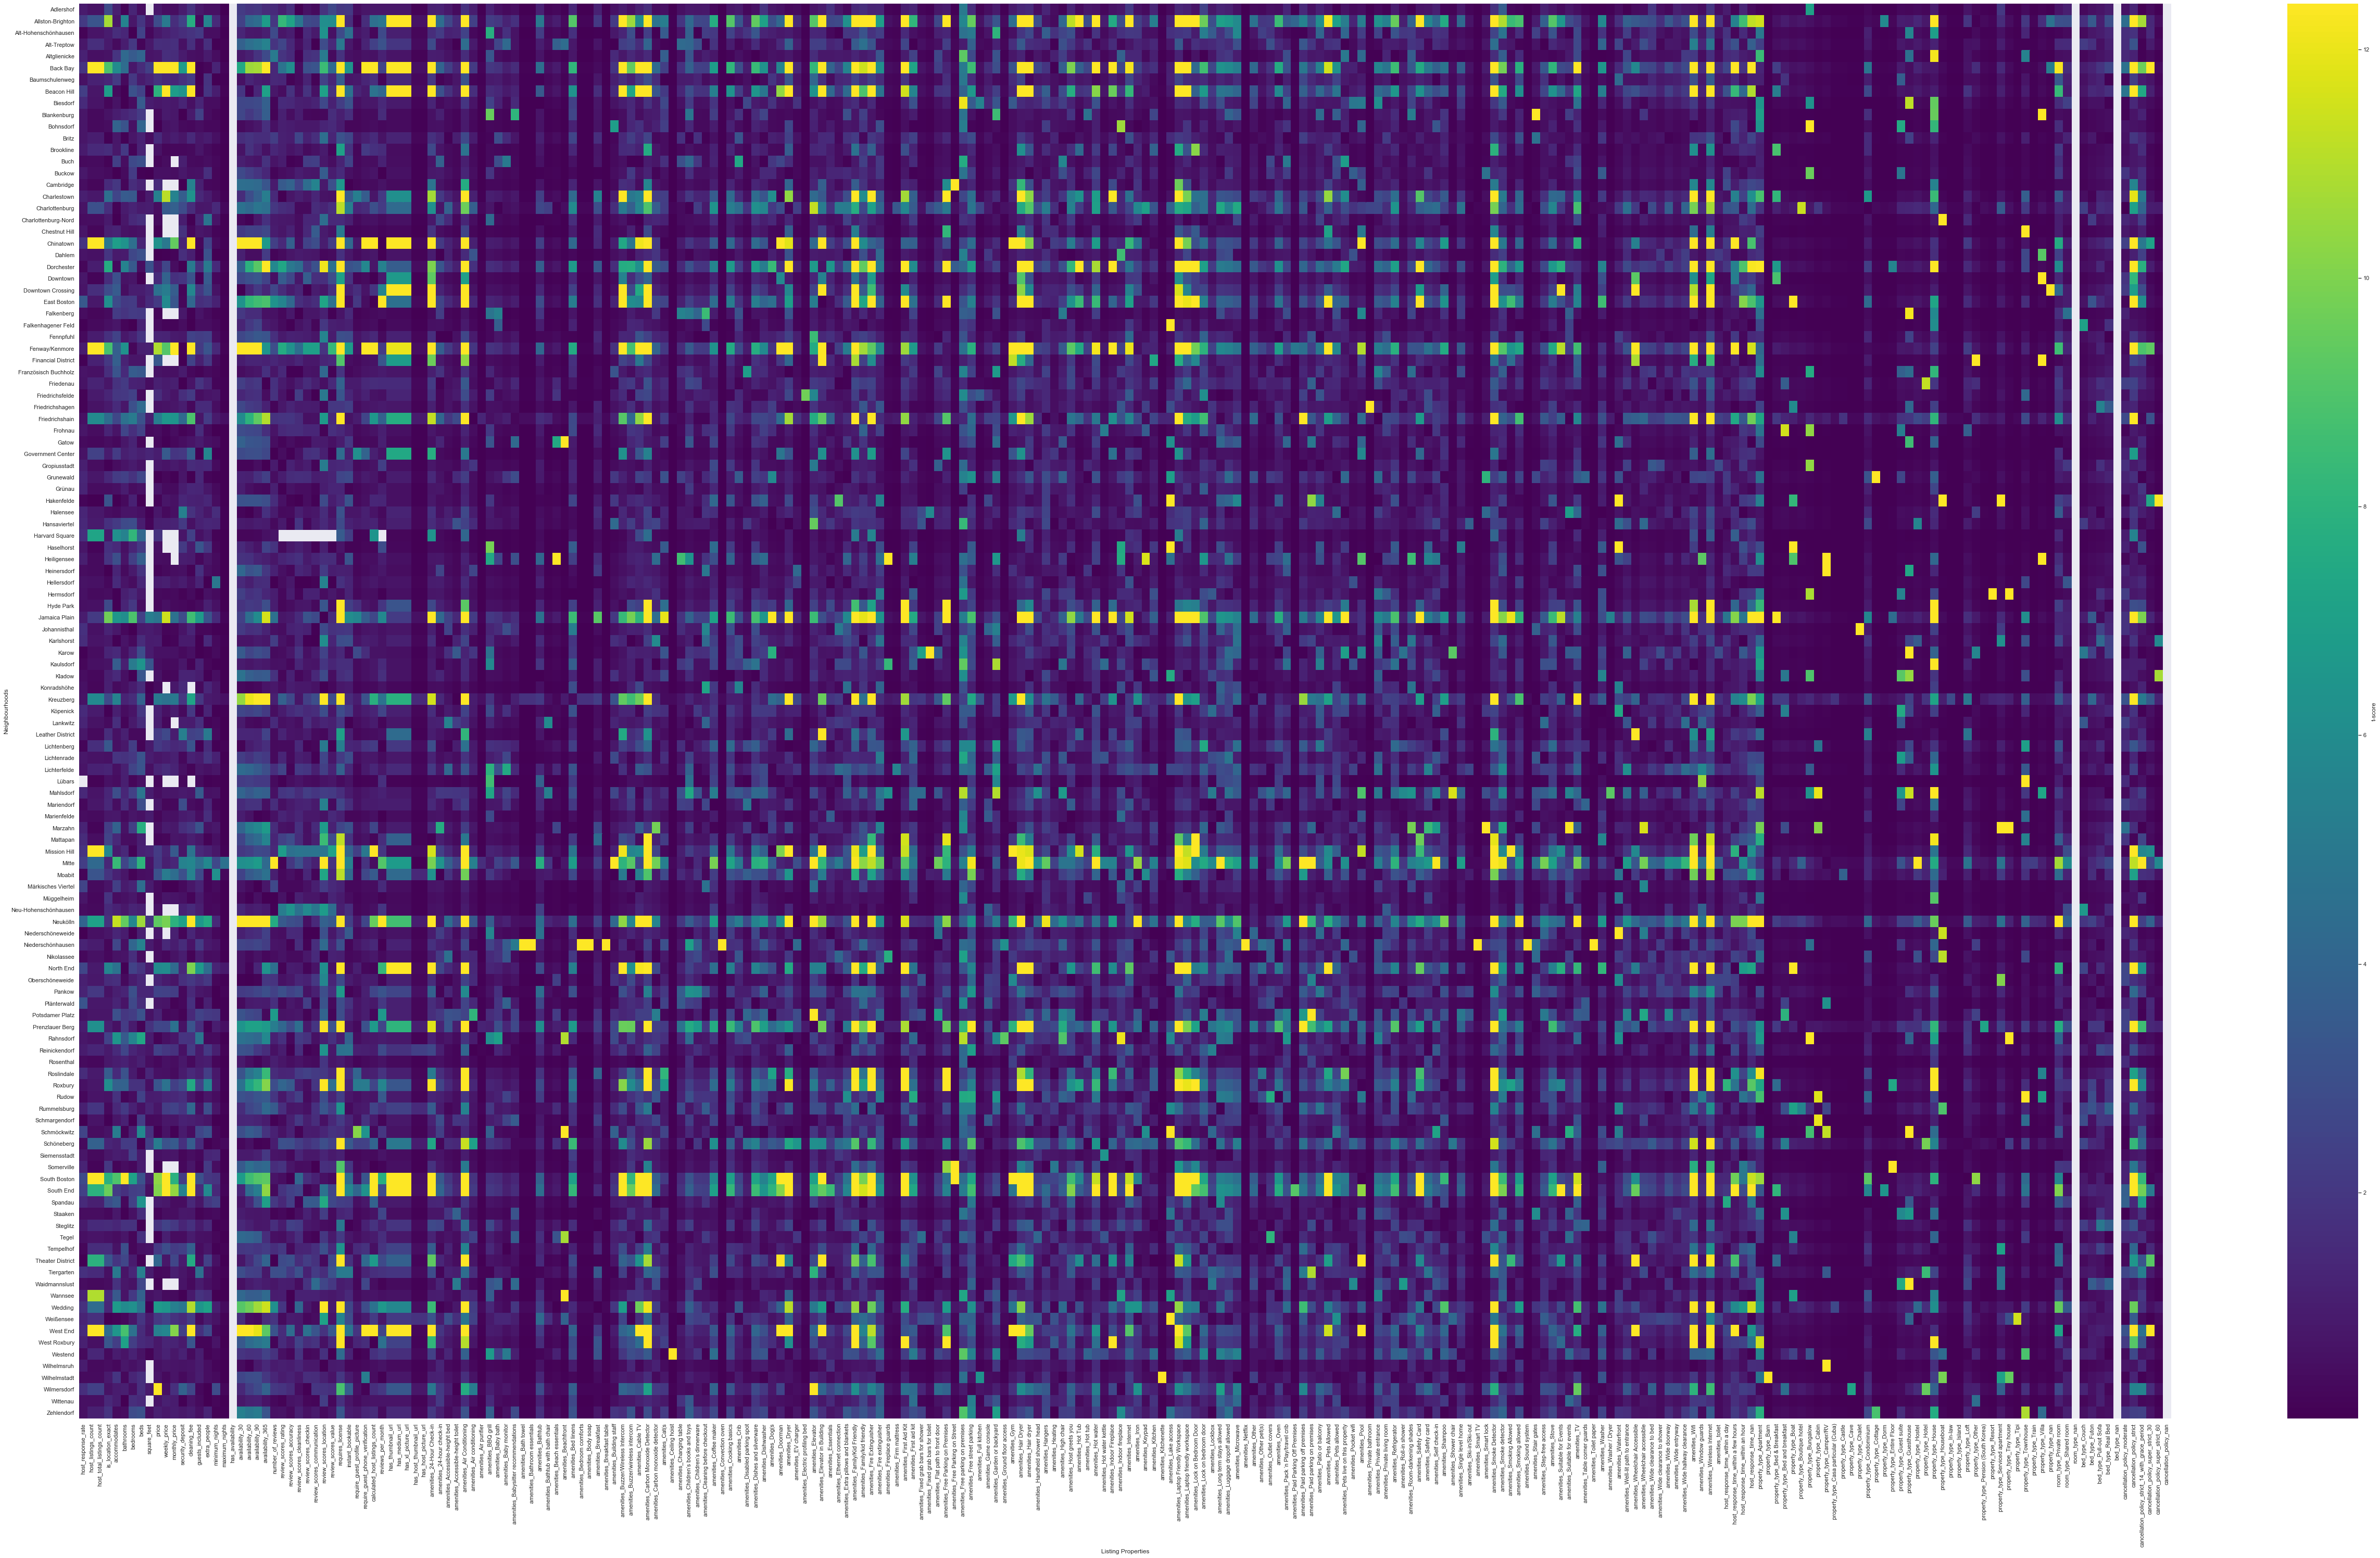

In [40]:
# neighborhood t-score heatmap
fix, ax = plt.subplots(figsize=(80,50))
sns.heatmap(nbh_t, annot=False, ax=ax, cmap='viridis', square=False, robust=True, cbar_kws={'fraction': 0.05,
                                                                                           'label': 't-score'})
ax.set_xlabel('Listing Properties')
ax.set_ylabel('Neighbourhoods')
plt.savefig('output/neighborhood_t-score_heatmap.png', bbox_inches='tight')

### Example: Spandau vs. Cambridge

In [54]:
(nbh_mean.loc['Cambridge'] - nbh_mean.loc['Spandau']) / (glob_std / np.sqrt(nbh_prop_counts.loc['Cambridge']))

host_response_rate                                -0.220533
host_listings_count                               -0.737002
host_total_listings_count                         -0.737002
is_location_exact                                  2.814579
accommodates                                       0.426850
                                                     ...   
cancellation_policy_strict                         6.339941
cancellation_policy_strict_14_with_grace_period   -4.689435
cancellation_policy_super_strict_30                0.000000
cancellation_policy_super_strict_60                0.000000
cancellation_policy_nan                                 NaN
Length: 252, dtype: float64

In [60]:
cambride_spandau_t = ((nbh_mean.loc[['Cambridge', 'Spandau']] - glob_mean) / \
   (glob_std / np.sqrt(nbh_prop_counts.loc[['Cambridge', 'Spandau']]))).transpose()
cambride_spandau_t['Cambridge_to_Spandau'] = (nbh_mean.loc['Cambridge'] - nbh_mean.loc['Spandau']) / (glob_std / np.sqrt(nbh_prop_counts.loc['Cambridge']))
cambride_spandau_t = cambride_spandau_t.abs().dropna(axis=0, how='all')
cambride_spandau_t.sort_values(by='Cambridge', inplace=True, ascending=False)
cambride_spandau_t.head(300)


neighbourhood,Cambridge,Spandau,Cambridge_to_Spandau
amenities_Free Parking on Street,20.322447,0.106615,20.371550
amenities_Laptop Friendly Workspace,9.630991,1.578041,10.357784
amenities_Hair Dryer,8.208195,1.567374,8.930075
amenities_Air Conditioning,7.606173,1.998127,8.526443
requires_license,6.627162,2.293305,7.683381
...,...,...,...
property_type_In-law,0.016365,0.035533,0.000000
property_type_Cave,0.016365,0.035533,0.000000
property_type_Barn,0.016365,0.035533,0.000000
weekly_price,NaN,0.827518,NaN


In [61]:
cambride_spandau_t.sort_values(by='Spandau', inplace=True, ascending=False)
cambride_spandau_t.head(300)


neighbourhood,Cambridge,Spandau,Cambridge_to_Spandau
host_response_time_within a day,2.969509,7.541050,0.503644
review_scores_location,0.891245,7.493818,1.228327
availability_365,3.273269,6.976295,0.060224
cancellation_policy_strict_14_with_grace_period,1.488957,6.949008,4.689435
beds,1.201247,6.311018,1.750461
...,...,...,...
amenities_Netflix,0.016365,0.035533,0.000000
amenities_Ceiling hoist,0.016365,0.035533,0.000000
property_type_In-law,0.016365,0.035533,0.000000
property_type_Cave,0.016365,0.035533,0.000000


In [62]:
cambride_spandau_t.to_csv('output/cambridge_spandau_t.csv', sep=';')
